# Image classification: dogs & cats

In [1]:
# Handle imports up-front
import os
import sys
import glob
import random

# Silence logging messages from TensorFlow, except errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# PyPI imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Import image from keras correctly based on the TensorFlow version
tf_version = float('.'.join(tf.__version__.split('.')[0:2]))
print(f'Tensorflow version {tf_version}')

if tf_version > 2.8:
    import keras.utils as image

else:
    from keras.preprocessing import image

# Figure out if we are running on Kaggle or not, if so
# add the location of utils.py to path so we can import
path_list = os.getcwd().split(os.sep)

if path_list[1] == 'kaggle':
    sys.path.append('/kaggle/usr/lib/image_classification_functions')

# Import custom helper functions from utils.py
from image_classification_functions import prep_data
from image_classification_functions import single_training_run
from image_classification_functions import plot_single_training_run
from image_classification_functions import hyperparameter_optimization_run
from image_classification_functions import plot_hyperparameter_optimization_run

# Silence logging messages from TensorFlow, except errors
tf.get_logger().setLevel('ERROR')


Tensorflow version 2.2


## 1. Data preparation

### 1.1. Load the data paths

In [2]:
# Decompress and organize the images
training_data_path, validation_data_path, testing_data_path = prep_data()

# Get lists of training and validation dog and cat images
training_dogs = glob.glob(f'{training_data_path}/dogs/dog.*')
training_cats = glob.glob(f'{training_data_path}/cats/cat.*')
validation_dogs = glob.glob(f'{validation_data_path}/dogs/dog.*')
validation_cats = glob.glob(f'{validation_data_path}/cats/cat.*')


Not running in Kaggle notebook
Checking data prep
Missing images, final count: 0
Running data prep
Image archive should be at ../data/images/raw/dogs-vs-cats.zip
Extracting ../data/images/raw/dogs-vs-cats.zip


Image extraction complete
Making training and testing datasets
Moving files to training, validation & testing, cat & dog subdirectories
Done


In [3]:
print("Training path:", training_data_path)
print("Validation path:", validation_data_path)
print("Testing path:", testing_data_path)

print("Number of training cat images:", len(training_cats))
print("Number of training dog images:", len(training_dogs))


Training path: ../data/images/training
Validation path: ../data/images/validation
Testing path: ../data/images/testing
Number of training cat images: 7500
Number of training dog images: 7500


### 1.2. Inspect

Number of cat images: 7500
Number of dog images: 7500
Cat path: ../data/images/training/cats/cat.12256.jpg
Dog path: ../data/images/training/dogs/dog.3873.jpg
Cat path: ../data/images/training/cats/cat.9903.jpg
Dog path: ../data/images/training/dogs/dog.3762.jpg
Cat path: ../data/images/training/cats/cat.11865.jpg
Dog path: ../data/images/training/dogs/dog.139.jpg


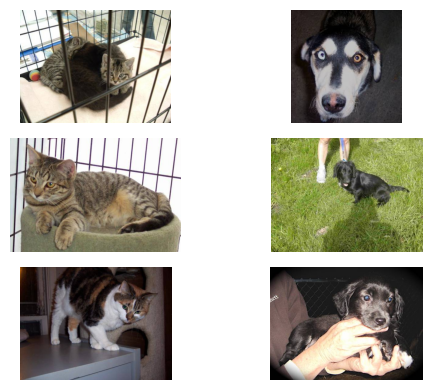

In [4]:
# Plot some of the cat and dog images
fig, axs = plt.subplots(3, 2, figsize=(6, 4))

print("Number of cat images:", len(training_cats))
print("Number of dog images:", len(training_dogs))

for cat, dog, row in zip(training_cats, training_dogs, axs):
    print("Cat path:", cat)
    print("Dog path:", dog)

    for animal, ax in zip([cat, dog], row):
        animal = image.load_img(animal)
        animal = image.img_to_array(animal)
        animal /= 255.0
        ax.imshow(animal)
        ax.axis('off')

fig.tight_layout()


## 2. EDA

Let's take a look at a few of our images to get a feel for how image data is structured.

### 2.1. Image data

Image shape: (318, 309, 3)


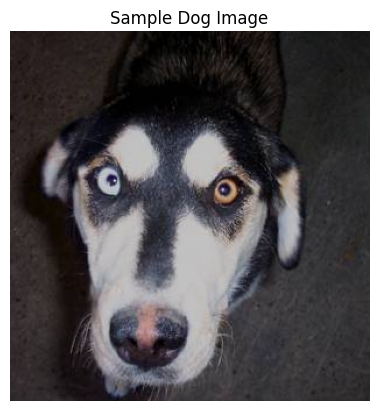

In [5]:
# Load one of the images as an array and look at it's shape - what do you see, what are the dimensions? Are they what you expect?

# Load a sample image 
sample_image_path = training_dogs[0]

# Load the image
sample_image = image.load_img(sample_image_path)

# Convert to array
sample_array = image.img_to_array(sample_image)

# Print shape
print(f"Image shape: {sample_array.shape}") 

# Display the image
plt.imshow(sample_array.astype("uint8"))
plt.title("Sample Dog Image")
plt.axis("off")
plt.show()


I see a huski with 2 different colored eyes, in terms of dimensions: looks like the length is longer than the width by a little. Color is clear and there is no blurr. 

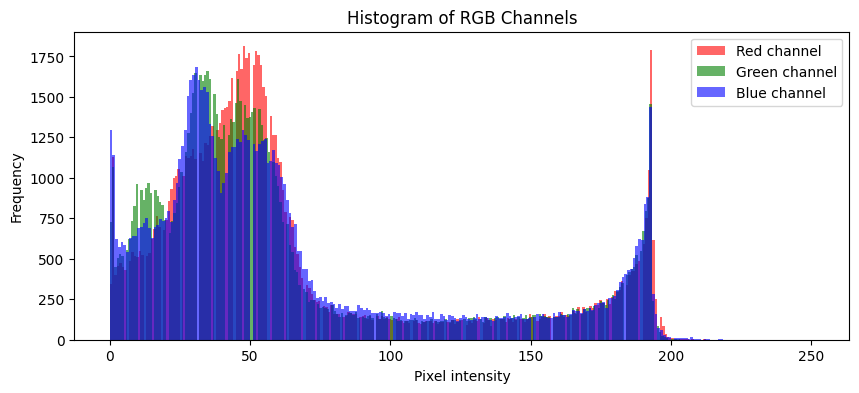

In [10]:
# Plot a histogram of the three 2D arrays which comprise the image. What do you see?
plt.figure(figsize=(10, 4))
colors = ['Red', 'Green', 'Blue']
for i in range(3):
    plt.hist(sample_array[:, :, i].ravel(), bins=256, color=colors[i].lower(), alpha=0.6, label=f'{colors[i]} channel')

plt.title("Histogram of RGB Channels")
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In this histogram, I see that there is an increase in frequency between 0 and 50 pixels and then it begins to decrease after 50 pixels, flattens at 100 and then begins to spike again around 175 pixels.  

### 2.2. Image dimensions

Let's take a look at a random sample of images from the dataset and see what their dimensions are.

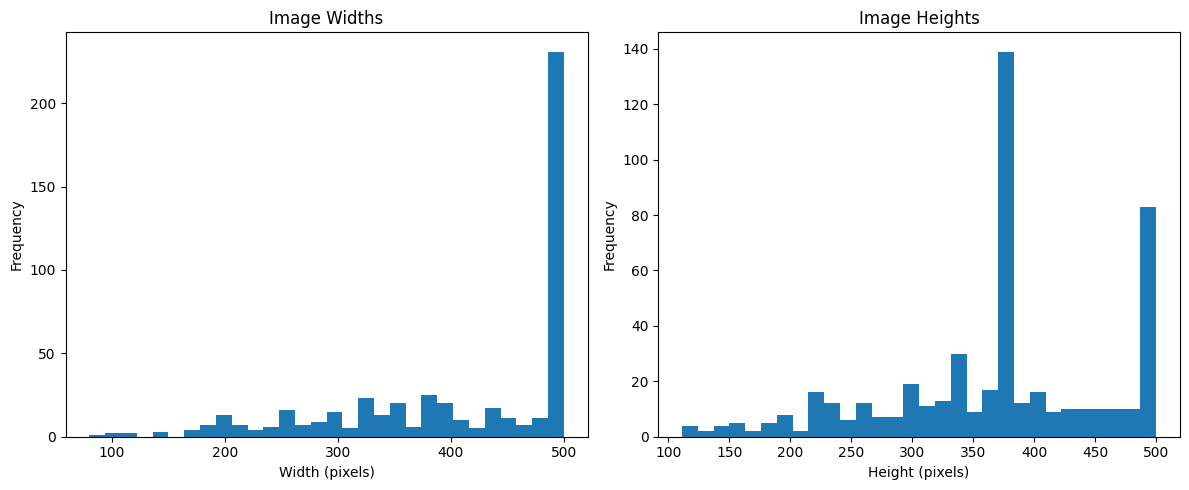

In [ ]:
# Loop over a few hundred images and extract their width and heigh, plot both as a histogram. What do you see, does this information matter to us, if so, how?

# Combine cat and dog training images
all_images = training_cats + training_dogs

# Sample a few hundred images
sample_size = 500
sample_paths = random.sample(all_images, sample_size)

# Collect widths and heights
widths = []
heights = []

for path in sample_paths:
    img = image.load_img(path)
    widths.append(img.size[0])   
    heights.append(img.size[1])  

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30)
plt.title("Image Widths")
plt.xlabel("Width (pixels)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30)
plt.title("Image Heights")
plt.xlabel("Height (pixels)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Looks like the frequency of images in the height histogram tend to be higher than that of those images within the width histogram. This may be useful when running the model since it could affect the speed at which it runs. 

### 2.3. Image aspect ratios

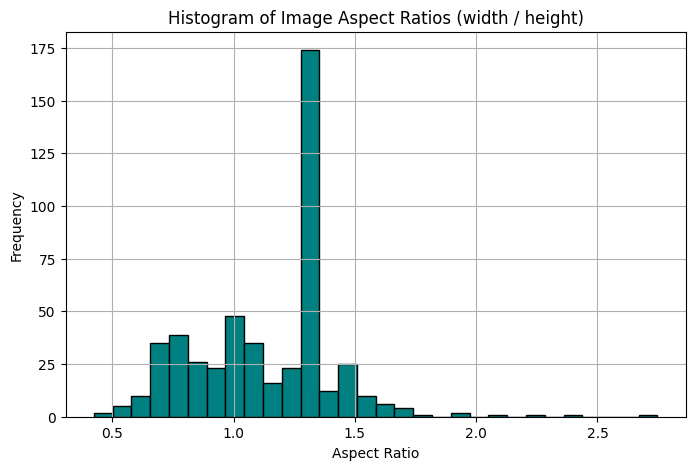

In [14]:
# Plot a histogram of the image aspect ratios (i.e. width/height) What do you see, does this information matter to us, if so, how?

# Compute aspect ratios for the same sample set
aspect_ratios = [w / h for w, h in zip(widths, heights)]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(aspect_ratios, bins=30, color='teal', edgecolor='black')
plt.title("Histogram of Image Aspect Ratios (width / height)")
plt.xlabel("Aspect Ratio")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


There's a tall spike at the 1.3 aspect ratio, which means most images share that ratio. Seems to also spike a little at 1.0 aspect ratio. Does this help us? Yes, because aspect ration affects the model input consistency. There may need to be resizing to help the model run more efficiently. 

## 3. Build the model

### 3.1. Prepare images for streaming

In [18]:
from typing import Tuple


def make_datasets(
        training_data_path: str,
        image_width: int,
        image_height: int, 
        batch_size: int=32,
        steps_per_epoch: int=50,
        epochs: int=10
) -> Tuple[tf.data.Dataset, tf.data.Dataset]:

    training_dataset, validation_dataset=tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='both',
        seed=315,
        shuffle=True,
        image_size=(image_width, image_height),
        batch_size=batch_size
    )

    epoch_images=batch_size*steps_per_epoch
    total_images=epoch_images*epochs

    training_dataset=training_dataset.cache().shuffle(total_images, reshuffle_each_iteration=True).prefetch(buffer_size=total_images).repeat()
    validation_dataset=training_dataset.cache().shuffle(total_images, reshuffle_each_iteration=True).prefetch(buffer_size=total_images).repeat()

    return training_dataset, validation_dataset


training_dataset, validation_dataset=make_datasets(
    training_data_path,
    image_width=64,
    image_height=48,
    batch_size=64,
    steps_per_epoch=50,
    epochs=100
)

Found 15000 files belonging to 2 classes.
Using 12000 files for training.
Using 3000 files for validation.


### 3.1. Model definition

In [21]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


def compile_model(image_width, image_height, learning_rate):

    initializer=tf.keras.initializers.GlorotUniform(seed=315)

    model=Sequential([
        layers.Input((image_width, image_height, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(1, activation='sigmoid', kernel_initializer=initializer)
    ])

    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

    return model


model=compile_model(
    image_width=64,
    image_height=48, 
    learning_rate=0.1
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 64, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 48, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417,057 (1.59 MB)

 Trainable params: 417,057 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2. Model training

In [22]:
%%time

training_results=model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=100,
  steps_per_epoch=50,
  validation_steps=50,
  verbose=0
)

print()


CPU times: user 25min 28s, sys: 1min 3s, total: 26min 32s
Wall time: 15min 46s


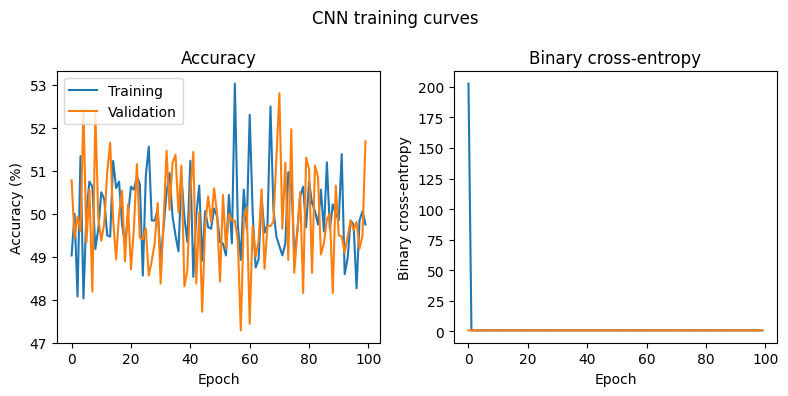

In [23]:
# Take a look the information 'training_results' contains. Plot the training 
# and validation accuracy (and binary cross-entropy if you like) over the
# training epochs. Is the model learning? If not, what do you think
# is wrong?
 
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('CNN training curves', size='large')

# Plot training and validation accuracy
axs[0].set_title('Accuracy')
axs[0].plot(np.array(training_results.history['binary_accuracy']) * 100, label='Training')
axs[0].plot(np.array(training_results.history['val_binary_accuracy']) * 100, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(loc='upper left')

# Plot training and validation binary cross-entropy
axs[1].set_title('Binary cross-entropy')
axs[1].plot(training_results.history['loss'])
axs[1].plot(training_results.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Binary cross-entropy')

# Show the plot
fig.tight_layout()

The accuracy is all over the place suggesting that the model is not learning as well as it should and the binary cross-entropy chart shows the model starting with a high initial value then dropping instantly. This suggests that it could be overfitting and isn't actually learning past the first step. 

### 3.3. Model optimization

In [25]:
# Try optimizing the learning rate and the batch size using a few values near the default settings. Hint: use a loop!
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [16, 32, 64]

results = []

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\n🔁 Training with learning_rate={lr}, batch_size={bs}")
        
        # Make datasets
        train_ds, val_ds = make_datasets(
            training_data_path,
            image_width=64,
            image_height=48,
            batch_size=bs,
            steps_per_epoch=20,
            epochs=5  
        )

        # Compile model
        model = compile_model(
            image_width=64,
            image_height=48,
            learning_rate=lr
        )

        # Train model
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=5,
            verbose=0  
        )

        # Get final val loss
        final_val_loss = history.history["val_loss"][-1]
        print(f"✅ Final val_loss: {final_val_loss:.4f}")

        results.append((lr, bs, final_val_loss))



🔁 Training with learning_rate=0.0001, batch_size=16
Found 15000 files belonging to 2 classes.
Using 12000 files for training.
Using 3000 files for validation.


KeyboardInterrupt: 

In [ ]:
# Pick the best values for learning rate and batch size and train the model for longer

# Sort results by lowest validation loss
results.sort(key=lambda x: x[2])

# Best combo
best_lr, best_bs, best_loss = results[0]
print(f"\n🏆 Best config → learning_rate={best_lr}, batch_size={best_bs}, val_loss={best_loss:.4f}")


## 4. Evaluate the model

In [ ]:
# Test the model out on the test data - is it as good as you expected, given the training data? Worse? Better? Why?